In [9]:
import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import jax
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.diagnostics import hpdi
from numpyro.infer import MCMC, NUTS, Predictive


#matplotlib.use("agg")

N_POINTS_PER_UNIT = 10  # number of points to plot for each unit interval
numpyro.set_host_device_count(4)

%matplotlib inline

## Data inspection

In [25]:
help(hpdi)

Help on function hpdi in module numpyro.diagnostics:

hpdi(x, prob=0.9, axis=0)
    Computes "highest posterior density interval" (HPDI) which is the narrowest
    interval with probability mass ``prob``.
    
    :param numpy.ndarray x: the input array.
    :param float prob: the probability mass of samples within the interval.
    :param int axis: the dimension to calculate hpdi.
    :return: quantiles of ``x`` at ``(1 - prob) / 2`` and
        ``(1 + prob) / 2``.
    :rtype: numpy.ndarray



In [10]:
full_df = pd.read_csv('data/all_steps.csv')
sub_df = full_df[-440*24:-420*24]
#sub_df.value = sub_df.value / sub_df.value.max()

data = sub_df.value

In [11]:
def split_train_test(d, ratio=0.9):
    samples = int(len(d)*ratio)
    y_train = jnp.array(data[:samples], dtype=jnp.float32)
    y_test = jnp.array(data[samples:], dtype=jnp.float32)
    return y_train, y_test

y_train, y_test = split_train_test(data, ratio=0.9)

In [12]:
print("Split:")
print(f"  Training: {len(y_train)}")
print(f"  Testing : {len(y_test)}")

Split:
  Training: 432
  Testing : 48


<Axes: >

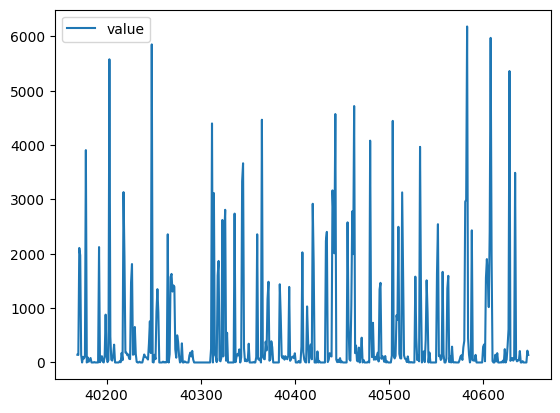

In [13]:
sub_df.plot()

In [14]:
_fft = np.fft.fft(y_train)
_freq = np.fft.fftfreq(len(y_train), 1)

idx = _freq>=1/(24*7*10)
freq = _freq[idx]
fft = np.abs(_fft[idx])

Text(0, 0.5, 'Power')

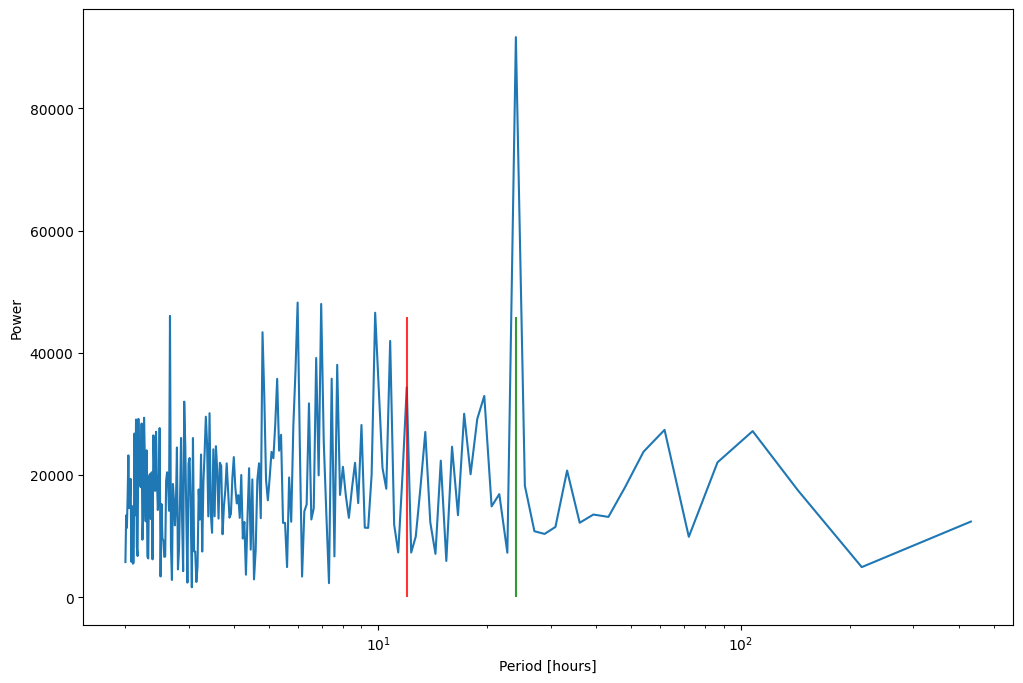

In [15]:
fix, ax = plt.subplots(1,1, figsize=(12,8))
ax.semilogx(1./freq, fft)
ax.vlines(12, 0, 0.5*fft.max(), colors='red', alpha=0.8)  # Half day period
ax.vlines(24, 0, 0.5*fft.max(), colors='green', alpha=0.8)  # Full day period

ax.set_xlabel("Period [hours]")
ax.set_ylabel("Power")

# Model

## Definition

In [16]:
def holt_winters(y, n_seasons, future=0):
    # Beta (1, 1) is uniform distribution
    T = y.shape[0]
    level_smoothing = numpyro.sample("level_smoothing", dist.Beta(1, 1))
    trend_smoothing = numpyro.sample("trend_smoothing", dist.Beta(1, 1))
    seasonality_smoothing = numpyro.sample("seasonality_smoothing", dist.Beta(1, 1))
    adj_seasonality_smoothing = seasonality_smoothing * (1 - level_smoothing)
    
    noise = numpyro.sample("noise", dist.HalfNormal(1))
    level_init = numpyro.sample("level_init", dist.Normal(0, 1))
    trend_init = numpyro.sample("trend_init", dist.Normal(0, 1))
    
    
    with numpyro.plate("n_seasons", n_seasons):
        seasonality_init = numpyro.sample("seasonality_init", dist.Normal(0, 1))

    def transition_fn(carry, t):
        previous_level, previous_trend, previous_seasonality = carry
        level = jnp.where(
            t < T,
            level_smoothing * (y[t] - previous_seasonality[0])
            + (1 - level_smoothing) * (previous_level + previous_trend),
            previous_level,
        )
        trend = jnp.where(
            t < T,
            trend_smoothing * (level - previous_level)
            + (1 - trend_smoothing) * previous_trend,
            previous_trend,
        )
        new_season = jnp.where(
            t < T,
            adj_seasonality_smoothing * (y[t] - (previous_level + previous_trend))
            + (1 - adj_seasonality_smoothing) * previous_seasonality[0],
            previous_seasonality[0],
        )
        step = jnp.where(t < T, 1, t - T + 1)
        mu = previous_level + step * previous_trend + previous_seasonality[0]
        pred = numpyro.sample("pred", dist.Normal(mu, noise))

        seasonality = jnp.concatenate(
            [previous_seasonality[1:], new_season[None]], axis=0
        )
        return (level, trend, seasonality), pred

    with numpyro.handlers.condition(data={"pred": y}):
        _, preds = scan(
            transition_fn,
            (level_init, trend_init, seasonality_init),
            jnp.arange(T + future),
        )

    if future > 0:
        numpyro.deterministic("y_forecast", preds[-future:])

## Training

In [18]:
%%time

n_seasons = 24

model = holt_winters
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=5000, num_samples=15000, num_chains=4)
mcmc.run(jax.random.PRNGKey(10), y_train, n_seasons=n_seasons)
mcmc.print_summary()
samples = mcmc.get_samples()


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]


                             mean       std    median      5.0%     95.0%     n_eff     r_hat
             level_init      0.63      1.00      0.63     -1.00      2.29  99624.40      1.00
        level_smoothing      0.01      0.00      0.01      0.01      0.01  90372.79      1.00
                  noise    141.09      0.50    141.09    140.27    141.91 110752.20      1.00
    seasonality_init[0]      0.02      1.00      0.02     -1.60      1.70  94960.60      1.00
    seasonality_init[1]      0.06      1.00      0.06     -1.59      1.68  95427.81      1.00
    seasonality_init[2]      0.04      0.99      0.04     -1.61      1.66  92009.45      1.00
    seasonality_init[3]      0.03      1.00      0.03     -1.61      1.68 100378.31      1.00
    seasonality_init[4]      0.12      1.00      0.12     -1.56      1.73  91358.74      1.00
    seasonality_init[5]      0.06      1.00      0.06     -1.62      1.65  97116.09      1.00
    seasonality_init[6]      0.09      1.00      0.09     -

## Forecasting

In [27]:
predictive = Predictive(model, samples, return_sites=["y_forecast"])
all_forecast_marginal = predictive(jax.random.PRNGKey(1), y_train, n_seasons=n_seasons, future=len(y_test))
forecast_marginal = all_forecast_marginal["y_forecast"]

In [28]:
all_forecast_marginal

{'y_forecast': Array([[ 299.72116 ,  740.4903  ,  230.50708 , ...,  173.74753 ,
          201.46974 , 1650.4012  ],
        [ 500.2011  ,  487.85956 ,  325.50912 , ...,   82.571945,
          381.7396  , 1770.4655  ],
        [ 536.9811  ,  294.61017 ,  585.91583 , ...,  128.88693 ,
          355.79968 , 1604.6394  ],
        ...,
        [ 289.66696 ,  579.4441  ,  595.66785 , ...,  225.30428 ,
          349.1509  , 1734.4814  ],
        [ 430.34714 ,  256.13507 ,  187.96996 , ...,  211.55533 ,
          250.1594  , 1684.8278  ],
        [ 580.2396  ,  522.3266  ,  250.2761  , ...,  -82.75058 ,
          371.06082 , 1762.0762  ]], dtype=float32)}

Shape of forecast is: 
$$(N_s * N_c, n) \rightarrow (15000 * 4, 48)$$
where
$N_s$ is number of samples, $N_c$ is number of chains and $n$ is the length of the forecast.

In [29]:
forecast_marginal.shape

(60000, 48)

In [30]:
y_pred = jnp.mean(forecast_marginal, axis=0)
# sMAPE - symetric mean absolute percentage error
MAPE = jnp.mean(jnp.abs( 1 - (y_pred / (y_test+1) ) )) * 100

sMAPE = jnp.mean(jnp.abs(y_pred - y_test) / (jnp.abs(y_pred) + jnp.abs(y_test)) ) * 100
msqrt = jnp.sqrt(jnp.mean((y_pred - y_test) ** 2))

print(f"MAPE: {MAPE:.2f}, sMAPE: {sMAPE:.2f}, rmse: {msqrt:.2f}")


MAPE: 11956.43, sMAPE: 72.51, rmse: 1312.57


HPDI - highest posterior density interval

In [31]:
help(hpdi)

Help on function hpdi in module numpyro.diagnostics:

hpdi(x, prob=0.9, axis=0)
    Computes "highest posterior density interval" (HPDI) which is the narrowest
    interval with probability mass ``prob``.
    
    :param numpy.ndarray x: the input array.
    :param float prob: the probability mass of samples within the interval.
    :param int axis: the dimension to calculate hpdi.
    :return: quantiles of ``x`` at ``(1 - prob) / 2`` and
        ``(1 + prob) / 2``.
    :rtype: numpy.ndarray



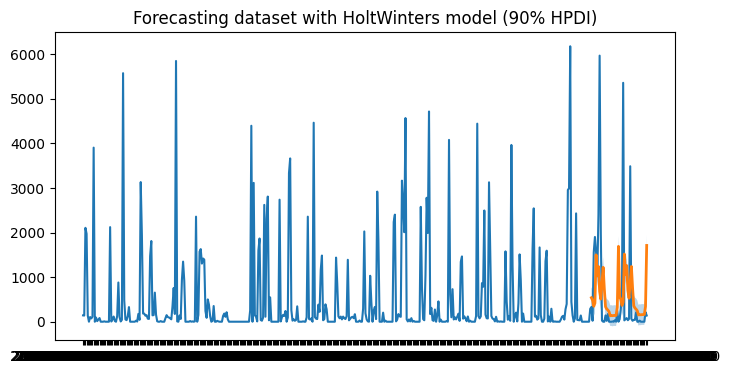

In [32]:
plt.figure(figsize=(8, 4))
plt.plot(sub_df['date'], data)
t_future = sub_df['date'][len(y_train):]
hpd_low, hpd_high = hpdi(forecast_marginal)

plt.plot(t_future, y_pred, lw=2)
plt.fill_between(t_future, hpd_low, hpd_high, alpha=0.3)
plt.title("Forecasting dataset with HoltWinters model (90% HPDI)")
plt.show();